#HW3 Questions:

A) 7.12

B) 9.7 and 9.12 - Use "MyosinV" dataset

C) 10.4 and 10.6 - Zero draws

D) 10.7 and 10.11 - Transcriptional bursts, use "Bursting" dataset

In [3]:
import os
import copy
from pathlib import Path
from numbers import Number
from collections import namedtuple
from typing import NamedTuple, List, Callable, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from matplotlib import rc
from IPython.display import HTML
plt.matplotlib.rcParams['animation.embed_limit'] = 2**128

from scipy.special import factorial
# from google.colab import drive

rng = np.random.default_rng()


# Q7.12 - Luria-Delbruck via Likelihood Maximization


### 4.16 helper functions for experiment and plotting

[ 82.  30.  25. 165.  61.  50.] 1024 [4 7 5 2 4 5]


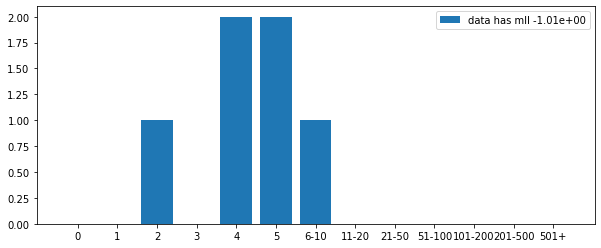

In [ ]:
def LD_experiment(c, n0, alpha_g, g):
  '''
  simulate a Luria-Delbruck experiment.
  Parameters:
  c: int - number of cultures of the experiment
  n0: int - number of bacteria at the start of the experiment
  alpha_g: float - probability of a bacteria to gain a resisting mutation
  g: int - number of generations

  Return a tuple (m, n, i_star) where:
  m: np.ndarray of size c - amount of mutated bacteria
  n: int - number of bacteria at the end of the experiment (n0*2**g)
  i_star: np.ndarray of size c - generation where first mutation appeared
  '''
  n = n0           # current bacteria count
  m = np.zeros(c)  # current mutated bacteria count

  i_star = np.full(c, g + 1)  # occurance of first mutation

  for step in range(g):
    n *= 2     # everybody divide
    m *= 2     # the mutants divided

    rates = alpha_g * (n - m)

    novel_ms = rng.poisson(rates)
    # novel_ms = np.zeros(c)
    # for culture in range(c):
    #   novel_ms[culture] = rng.poisson(rates[culture], size=1)

    i_star[(i_star > step) & (novel_ms > 0)] = step
    m += novel_ms  # add the novel mutatnst to the mutants count

  return m, n, i_star


def get_LD_bins_and_labels():
  bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 10.5, 20.5, 50.5, 100.5, 200.5, 500.5, 1e5]
  bin_labels = ['0', '1', '2', '3', '4', '5', '6-10', '11-20',
                '21-50', '51-100', '101-200', '201-500', '501+']
  return bins, bin_labels


def LD_plot_hist(data, ax=None, label=None, density=False):
  bins, bin_labels = get_LD_bins_and_labels()
  n_bins = len(bins) - 1

  hist, bin_edges = np.histogram(data, bins) # make the histogram

  if density:
    hist = hist / len(data)

  if ax is None:
    fig, ax = plt.subplots(figsize=(10, 4))
  else:
    fig = ax.get_figure()

  # Plot the histogram heights against integers on the x axis
  ax.bar(range(n_bins), hist, width=0.8, label=label)

  # Set the ticks to the middle of the bars
  ax.set_xticks(range(n_bins))

  # Set the xticklabels to a string that tells us what the bin edges were
  ax.set_xticklabels(bin_labels)

  return fig, ax


def data_to_probabilities(data, epsilon=1e-20):
  bins, bin_labels = get_LD_bins_and_labels()
  hist, bin_edges = np.histogram(data, bins)

  prob_per_bin = hist / len(data) + epsilon
  return prob_per_bin


def calculate_mll_of_exp(m, probs=None):
  ''' Calculate the mean log-likelihood of the data according to probs
  If no probabilities are providded, uses the data as the estimation'''
  bins, bin_labels = get_LD_bins_and_labels()

  hist, bin_edges = np.histogram(m, bins) # make the histogram

  if probs is None:
    probs = data_to_probabilities(m)

  log_prob = np.log(probs)
  return log_prob.T @ hist / len(m)


m, n, i_star = LD_experiment(6, 1, 0.01, 10)
print(m, n, i_star)

mll = calculate_mll_of_exp(m)

# fig, ax = LD_plot_hist(i_star, label='test', density=True)
fig, ax = LD_plot_hist(i_star, label=f'data has mll {mll: .2e}')
plt.legend()
plt.show(fig)

### Estimating $n_0$ so that after $g=21$ doublings we have $2.4 \cdot 10^8$ bacteria

In [ ]:
g = 21
n0 = int(2.4 * 10**8 / 2**g)
print(f'n0 is chosen to be {n0}, giving {n0 * 2**g: .2e} bacteria after {g} generations')

n0 is chosen to be 114, giving  2.39e+08 bacteria after 21 generations


### Obtaining dataset 6 - LD experiment 23
Plotting, and calculating the likelihood of the experiment given its own data


In [ ]:
ld23 = np.load(np.DataSource().open('http://www.physics.upenn.edu/biophys/PMLS2e/Datasets/LDexpt/LDexpt23.npy', "rb"))
ld23

array([[0.000e+00, 2.900e+01],
       [1.000e+00, 1.700e+01],
       [2.000e+00, 4.000e+00],
       [3.000e+00, 3.000e+00],
       [4.000e+00, 3.000e+00],
       [5.000e+00, 2.000e+00],
       [6.000e+00, 5.000e+00],
       [1.100e+01, 6.000e+00],
       [2.100e+01, 7.000e+00],
       [5.100e+01, 5.000e+00],
       [1.010e+02, 2.000e+00],
       [2.010e+02, 4.000e+00],
       [5.010e+02, 0.000e+00],
       [1.001e+03, 0.000e+00]])

In [ ]:
# removing the last empty bin
ld23 = ld23[:13]
ld23

array([[  0.,  29.],
       [  1.,  17.],
       [  2.,   4.],
       [  3.,   3.],
       [  4.,   3.],
       [  5.,   2.],
       [  6.,   5.],
       [ 11.,   6.],
       [ 21.,   7.],
       [ 51.,   5.],
       [101.,   2.],
       [201.,   4.],
       [501.,   0.]])

Experiment 23 included 87 cultures


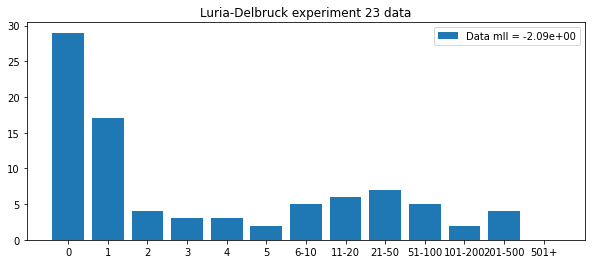

In [ ]:
ld_c = int(ld23[:, 1].sum())  # cultures in the LD experiments
print(f'Experiment 23 included {ld_c} cultures')

# getting the estimated data from LD in a form similar to our data
ld_m = [pair[0] for pair in ld23 for i in range(int(pair[1]))]

# turning the data to a pmf
ld_probs = data_to_probabilities(ld_m)

# calculating likelihood using the pmf
ld_mll = calculate_mll_of_exp(ld_m, ld_probs)

fig, ax = LD_plot_hist(ld_m, label=f'Data mll = {ld_mll: .2e}')
ax.set_title('Luria-Delbruck experiment 23 data')

ax.legend()
fig.show()

### Testing different $\alpha_g$ values


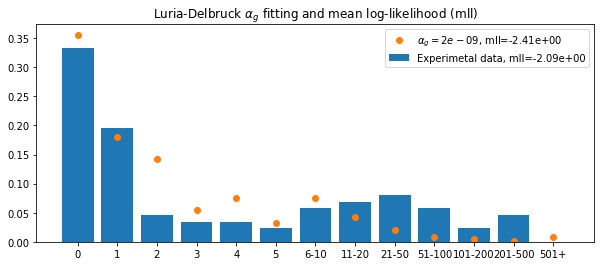

In [ ]:
c = 500          # number of cultures
alpha_g = 2e-9   # mutation rate

m, n, i_star = LD_experiment(c, n0, alpha_g, g)

probs = data_to_probabilities(m)

mll = calculate_mll_of_exp(ld_m, probs)

fig, ax = LD_plot_hist(ld_m, density=True, label=f'Experimetal data, mll={ld_mll: .2e}')
ax.set_title(r'Luria-Delbruck $\alpha_g$ fitting and mean log-likelihood (mll)')

ax.scatter(range(len(probs)), probs, zorder=2, label=fr'$\alpha_g={alpha_g}$, mll={mll: .2e}')

ax.legend()
fig.show()

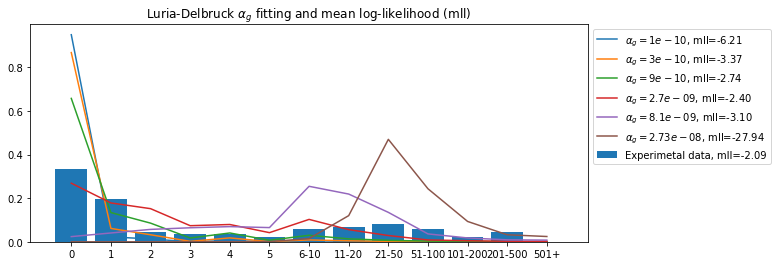

In [ ]:
c = 10000          # number of cultures
alpha_gs = [1e-10, 3e-10, 9e-10, 2.7e-9, 8.1e-9, 2.73e-8]   # mutation rate

bins, bin_labels = get_LD_bins_and_labels()
fig, ax = LD_plot_hist(ld_m, density=True, label=f'Experimetal data, mll={ld_mll: .2f}')

for alpha_g in alpha_gs:
  m, n, i_star = LD_experiment(c, n0, alpha_g, g)
  probs = data_to_probabilities(m)

  mll = calculate_mll_of_exp(ld_m, probs)

  hist, bin_edges = np.histogram(m, bins) # make the histogram
  density = hist / c

  ax.plot(range(len(density)), density, zorder=2, label=fr'$\alpha_g={alpha_g}$, mll={mll: .2f}')


ax.set_title(r'Luria-Delbruck $\alpha_g$ fitting and mean log-likelihood (mll)')
ax.legend(bbox_to_anchor=(1, 1))
# ax.set_yscale('log')
plt.show(fig)

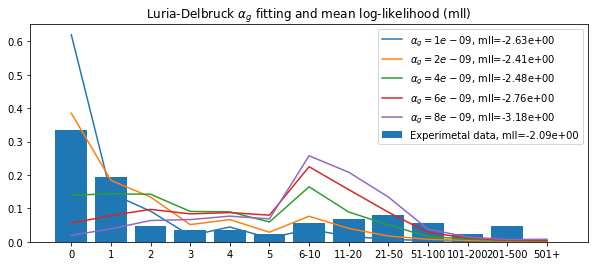

In [ ]:
c = 10000          # number of cultures
alpha_gs = [1e-9, 2e-9, 4e-9, 6e-9, 8e-9]   # mutation rate

bins, bin_labels = get_LD_bins_and_labels()
fig, ax = LD_plot_hist(ld_m, density=True, label=f'Experimetal data, mll={ld_mll: .2e}')

for alpha_g in alpha_gs:
  m, n, i_star = LD_experiment(c, n0, alpha_g, g)
  probs = data_to_probabilities(m)

  mll = calculate_mll_of_exp(ld_m, probs)

  hist, bin_edges = np.histogram(m, bins) # make the histogram
  density = hist / c

  ax.plot(range(len(density)), density, zorder=2, label=fr'$\alpha_g={alpha_g}$, mll={mll: .2e}')

ax.set_title(r'Luria-Delbruck $\alpha_g$ fitting and mean log-likelihood (mll)')
ax.legend(bbox_to_anchor=(1, 1))
# ax.set_yscale('log')

fig.show()

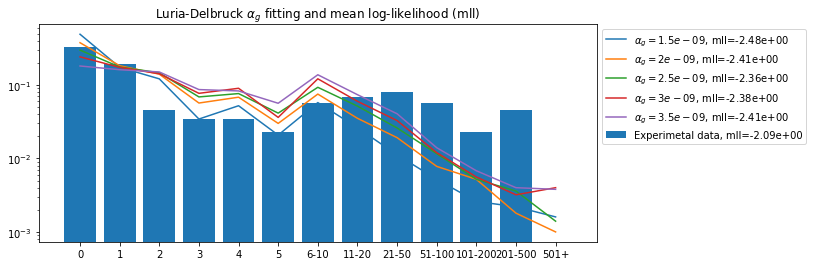

In [ ]:
c = 5000          # number of cultures
alpha_gs = [1.5e-9, 2.0e-9, 2.5e-9, 3e-9, 3.5e-9]   # mutation rate

bins, bin_labels = get_LD_bins_and_labels()
fig, ax = LD_plot_hist(ld_m, density=True, label=f'Experimetal data, mll={ld_mll: .2e}')

for alpha_g in alpha_gs:
  m, n, i_star = LD_experiment(c, n0, alpha_g, g)
  probs = data_to_probabilities(m)

  mll = calculate_mll_of_exp(ld_m, probs)

  hist, bin_edges = np.histogram(m, bins) # make the histogram
  density = hist / c

  ax.plot(range(len(density)), density, zorder=2, label=fr'$\alpha_g={alpha_g}$, mll={mll: .2e}')


ax.set_title(r'Luria-Delbruck $\alpha_g$ fitting and mean log-likelihood (mll)')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_yscale('log')

fig.show()

### Estimator and credible interval estimation
Given the tests preformed, our best estimator for the mutation rate is $\alpha_g ≈ 2.7\cdot 10^{-9}$.

I estimate the credible interval to be  $[2 \cdot 10^{-10}, 2 \cdot 10^{-8}]$, as this is the area where the mean log-likelihood is the highest

# Q9.7 Likelihood analysis of a Poisson process


We have waiting times $t_1,...,t_5$, where $p(t)=Ae^{-\beta t}$

a) $A$, the normalization constant should be selected such that $\int_0^{\infty}p(t)dt = \int_0^{\infty}Ae^{-\beta t}dt = 1$.

As $\int_0^{\infty}e^{-\beta t}dt =
-\frac{1}{beta} e^{-\beta t}|^{\infty}_0 = 0-(-\frac{1}{beta}) =
\frac{1}{beta}$

**We must conclud $A = \beta$**

A pdf should have units one over the units of the random variable, meaning the if $t$ has units of time than $p(t)$ must have units of rate. **Selecting the units of $\beta$ to be rate** we get $p(t)=time^{-1} e^{-time^{-1} t} = time^{-1} \cdot (dimensionless) = time^{-1}$

b) The per measurement likelihood is $L(t_i;\beta) = \beta e^{-\beta t_i}$. Assuming the waiting times are independent, the overall likelihood for the series is the product of per-measurement likelihoods:

$
L(\{t\}_{i=1}^5; \beta) =
\prod_{i=1}^5 (t_i;\beta) =
 \beta e^{-\beta t_i} =
\beta^5 e^{-\beta \sum_{i=1}^5 t_i}$

c) To maximize the likelihood we can maximize the log likelihood:

$
argmax_{\beta} L(\{t\}_{i=1}^5; \beta) =
argmax_{\beta} log(L(\{t\}_{i=1}^5; \beta)) =
argmax_{\beta} 5 log(\beta) - \beta \sum_{i=1}^5 t_i
$

Comparing deriving and comparing to zero we get:

$$
0 = \frac{5}{\beta} -  \sum_{i=1}^5 t_i \\
\beta = \frac{5}{\sum_{i=1}^5 t_i} = \bar{t}^{-1}
$$
meaning the rate is the inverse of the average

# Q9.12 Hidden steps in myosin-V
Two classes of motor molecules stepping, either two steps of alternating lengths or a single length with a hidden step. The waiting times of the first class are modeled as exponential, while the second are modeled as a Gamma distribution with shape 2 of the same rate.

## a) obtaining dataset 14, and generating historgrams

Green class - two steps $Exponential(\beta)$

Red class - one step $Gamma(2, \beta)$ a.k.a. hidden step

In [ ]:
g_class = pd.read_csv('http://www.physics.upenn.edu/biophys/PMLS2e/Datasets/MyosinV/yildizHistoGreen.csv', header=None, names=['bins_center', 'counts'])
r_class = pd.read_csv('http://www.physics.upenn.edu/biophys/PMLS2e/Datasets/MyosinV/yildizHistoRed.csv', header=None, names=['bins_center', 'counts'])
g_class['probs'] = g_class['counts'] / g_class['counts'].sum()
r_class['probs'] = r_class['counts'] / r_class['counts'].sum()

Green class


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
bins_center,0.500000,1.500000,2.500000,3.500000,4.500000,5.500000,6.500000,7.500000,8.500000,9.500000,10.500000,11.500000,12.500000,13.500000
counts,39.000000,36.000000,31.000000,19.000000,14.000000,8.000000,5.000000,3.000000,6.000000,3.000000,1.000000,3.000000,1.000000,1.000000
probs,0.229412,0.211765,0.182353,0.111765,0.082353,0.047059,0.029412,0.017647,0.035294,0.017647,0.005882,0.017647,0.005882,0.005882


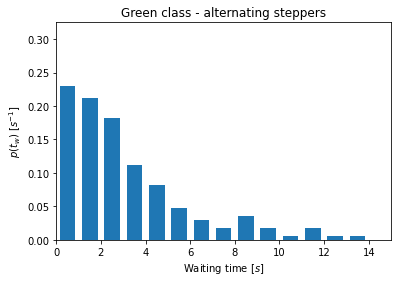

In [ ]:
print('Green class')

plt.bar('bins_center', 'probs', width=0.7, data=g_class)

g_xmin, g_xmax = 0, 15
plt.xlim((g_xmin, g_xmax))
plt.xlabel('Waiting time $[s]$')

plt.ylim((0, 0.325))
plt.ylabel('$p(t_w)$ $[s^{-1}]$')
plt.title('Green class - alternating steppers')

g_class.T

Red class


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
bins_center,0.25,0.750000,1.250000,1.750000,2.250000,2.750000,3.250000,3.75000,4.250000,4.750000,...,22.75,23.25000,23.75,24.25,24.75,25.25,25.75000,26.25,26.75000,27.25
counts,0.00,11.000000,15.000000,19.000000,22.000000,23.000000,23.000000,20.00000,15.000000,18.000000,...,0.00,1.00000,0.00,0.00,0.00,0.00,1.00000,0.00,1.00000,0.00
probs,0.00,0.033435,0.045593,0.057751,0.066869,0.069909,0.069909,0.06079,0.045593,0.054711,...,0.00,0.00304,0.00,0.00,0.00,0.00,0.00304,0.00,0.00304,0.00


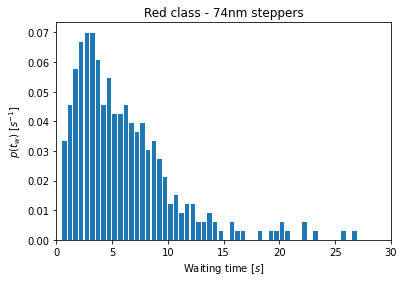

In [ ]:
print('Red class')

plt.bar('bins_center', 'probs', width=0.4, data=r_class)

r_xmin, r_xmax = 0, 30
plt.xlim((r_xmin, r_xmax))
plt.xlabel('Waiting time $[s]$')

plt.ylabel('$p(t_w)$ $[s^{-1}]$')
plt.title('Red class - 74nm steppers')

r_class.T

## b) Estimating $\beta$ for the green class
As in Q9.7, our ML estimator of $\beta$ is one over the average.

In [ ]:
g_mean = np.sum(g_class['probs'] * g_class['bins_center'])
g_beta = g_mean**(-1)
print(f'Beta is {g_beta: .2f}, which is one over the average {g_mean}')

Beta is  0.32, which is one over the average 3.11764705882353


## c) Plotting with a PDF


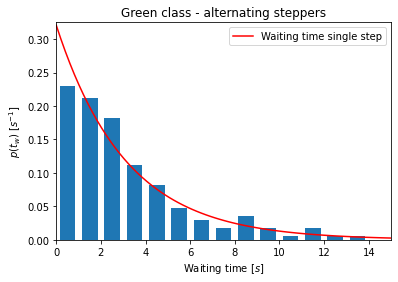

In [ ]:
g_grid = np.linspace(g_xmin, g_xmax, g_xmax * 5)

plt.bar('bins_center', 'probs', width=0.7, data=g_class)

plt.xlim((g_xmin, g_xmax))
plt.xlabel('Waiting time $[s]$')

plt.ylim((0, 0.325))
plt.ylabel('$p(t_w)$ $[s^{-1}]$')
plt.title('Green class - alternating steppers')

_ = plt.plot(g_grid, g_beta * np.exp(-g_beta * g_grid), c='r', label='Waiting time single step')
plt.legend()
plt.show()

## d) Estimating beta for the red class
If we consider every other step is missing, we can assume the real average waiting time was half of the observed average waiting time, and view that as the rate parameter of the exponential distribution:

Beta is  0.33, which is one over half the average  6.05


[]

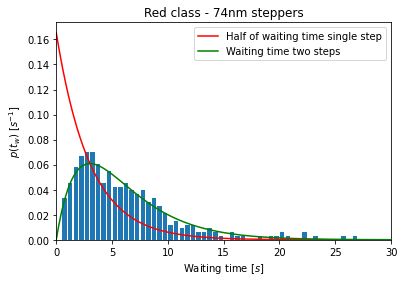

In [ ]:
r_observed_mean = np.sum(r_class['probs'] * r_class['bins_center'])
r_true_mean = r_observed_mean / 2
r_beta = r_true_mean**(-1)
print(f'Beta is {r_beta: .2f}, which is one over half the average {r_observed_mean: .2f}')

r_grid = np.linspace(r_xmin, r_xmax, r_xmax*5)

plt.bar('bins_center', 'probs', width=0.4, data=r_class)

r_xmin, r_xmax = 0, 30
plt.xlim((r_xmin, r_xmax))
plt.xlabel('Waiting time $[s]$')

plt.ylabel('$p(t_w)$ $[s^{-1}]$')
plt.title('Red class - 74nm steppers')

plt.plot(r_grid, 0.5 * r_beta * np.exp(-r_beta * r_grid), c='r', label='Half of waiting time single step')
plt.plot(r_grid, r_beta**2 / 2 * r_grid * np.exp(-r_beta * r_grid), c='g', label='Waiting time two steps')

plt.legend()
plt.plot()

## e) Beta values comparison
Both beta values were the same, matching the hypothesis of a hidden step, and allowing us to nicely fit the gamma distribution

## f) A process showing the last of m sequential events
for m=10 we expect to have a gamma distribution with shape 10 and the same rate. As this is a sum of limited variance probabilities, according to the central limit theory it is expected to have a mean of $10 \beta$ and an almost Gaussian distribution around that mean with variance $10 \beta^{-2}$

# Q10.4 and Q10.6 - Gillespie Algorithm simulations


## Your Turn 10C - Object Oriented Gillespie algorithm


In [5]:
class Event():
  '''
  General class for possible events to happend
  rate_function: fiven the current state, at what rate does the event occur
  event_function: how does the state change
  '''
  def __init__(self,
               rate_funciton: Callable[[NamedTuple], float],
               event_function: Callable[[NamedTuple], NamedTuple]):
    self.rate = rate_funciton
    self.effect = event_function

def gillespie_simulation(
  T: Number,
  ini_state: NamedTuple,
  events: List[Event],
  verbrose: bool=False) -> Tuple[List[float], List[NamedTuple]]:
  num_events = len(events)

  ts = [0]
  states = [ini_state]

  while ts[-1] < T:
    # gather rates
    rates = np.array([event.rate(states[-1]) for event in events])

    if verbrose:
      print(f'Time {ts[-1]: .2f}, state is {states[-1]}\nrates are {rates}')
    ts.append(ts[-1] + rng.exponential(rates.sum()**-1)) # rng uses scale parameterization
    if ts[-1] > T:
      ts.pop()
      break

    event_index = rng.choice(num_events, p=rates/sum(rates))

    states.append(events[event_index].effect(states[-1]))

  return ts, states


In [11]:
BasicState = namedtuple('BasicState', ['mRNA'])

class BirthEvent(Event):
  def __init__(self, beta_synthesis):
    def rate_function(state):
      return beta_synthesis

    def event_function(state):
      return state._replace(mRNA=state.mRNA + 1)

    super().__init__(rate_function, event_function)

class DeathEvent(Event):
  def __init__(self, clearance_rate):
    def rate_function(state):
      return state.mRNA * clearance_rate

    def event_function(state):
      return state._replace(mRNA=state.mRNA - 1)

    super().__init__(rate_function, event_function)


beta_s = 0.15  # beta_synthesis [min^-1]
k_null = 0.014  # clearance_rate [min^-1]

ts, states = gillespie_simulation(
    25, BasicState(0), [BirthEvent(beta_s), DeathEvent(k_null)], verbrose=True)

results_df = pd.DataFrame(states, columns=BasicState._fields)
results_df.insert(0, 'time', ts)
results_df


Time  0.00, state is BasicState(mRNA=0)
rates are [0.15 0.  ]
Time  10.44, state is BasicState(mRNA=1)
rates are [0.15  0.014]
Time  14.83, state is BasicState(mRNA=2)
rates are [0.15  0.028]
Time  19.75, state is BasicState(mRNA=3)
rates are [0.15  0.042]
Time  21.97, state is BasicState(mRNA=4)
rates are [0.15  0.056]


,time,mRNA
0,0.000000,0
1,10.439007,1
2,14.828486,2
3,19.747066,3
4,21.965017,4


In [9]:
def wrapper(repeats, T, ini_state, events):
  dfs = []
  for repeat in range(repeats):
    ts, states = gillespie_simulation(T, ini_state, copy.deepcopy(events))

    dfs.append(pd.DataFrame(states, columns=ini_state._fields))
    dfs[-1].insert(0, 'repeat', repeat)
    dfs[-1].insert(1, 'time', ts)

  return pd.concat(dfs).reset_index(drop=True)


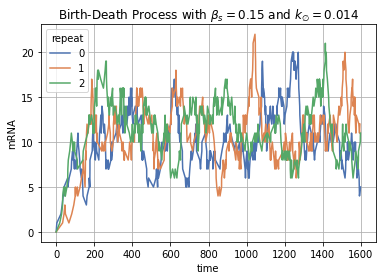

In [ ]:
beta_s = 0.15  # beta_synthesis [min^-1]
k_null = 0.014  # clearance_rate [min^-1]

results_df = wrapper(3, 1600, BasicState(0), [BirthEvent(beta_s), DeathEvent(k_null)])

g = sns.lineplot(x='time', y='mRNA', hue='repeat', data=results_df, palette='deep')
plt.grid()
plt.title(fr'Birth-Death Process with $\beta_s={beta_s}$ and $k_{{\varnothing}}={k_null}$')
plt.show()

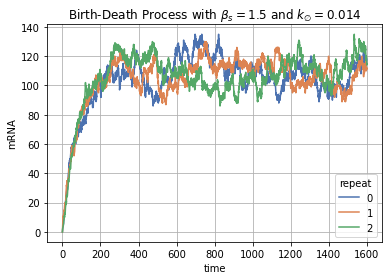

In [ ]:
beta_s = 1.5  # beta_synthesis [min^-1]
k_null = 0.014  # clearance_rate [min^-1]

results_df = wrapper(3, 1600, BasicState(0), [BirthEvent(beta_s), DeathEvent(k_null)])

g = sns.lineplot(x='time', y='mRNA', hue='repeat', data=results_df, palette='deep')
plt.grid()
plt.title(fr'Birth-Death Process with $\beta_s={beta_s}$ and $k_{{\varnothing}}={k_null}$')
plt.show()

## Q10.4 Average over many draws
Runnig the experiment 150 times for 300 minutes.

In [ ]:
beta_s = 0.15  # beta_synthesis [min^-1]
k_null = 0.014  # clearance_rate [min^-1]

reps = 300

results_df = wrapper(reps, 300, BasicState(0), [BirthEvent(beta_s), DeathEvent(k_null)])
results_df

,repeat,time,mRNA
0,0,0.000000,0
1,0,3.951331,1
2,0,4.012331,0
3,0,15.458737,1
4,0,34.661310,0
...,...,...,...
24427,299,293.776992,11
24428,299,295.833049,12
24429,299,295.881491,11
24430,299,296.390113,12


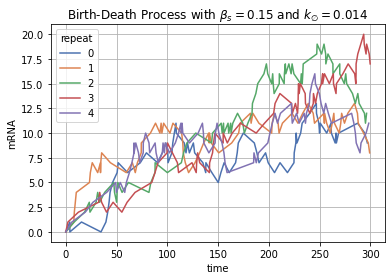

In [ ]:
g = sns.lineplot(x='time', y='mRNA', hue='repeat', palette='deep',
                 data=results_df[results_df.repeat < 5])
plt.grid()
plt.title(fr'Birth-Death Process with $\beta_s={beta_s}$ and $k_{{\varnothing}}={k_null}$')
plt.show()

In [ ]:
grid = np.arange(0, 300, 1)
means = np.zeros_like(grid, dtype='float')
stds = np.zeros_like(grid, dtype='float')
for i, t in enumerate(grid):
  idxmax = results_df[results_df.time <= t].groupby(['repeat'], sort=False)['time'].idxmax()
  mRNA = results_df.loc[idxmax, 'mRNA']
  means[i] = mRNA.mean()
  stds[i] = mRNA.std()
means[:5]

array([0.        , 0.18666667, 0.36333333, 0.46333333, 0.61      ])

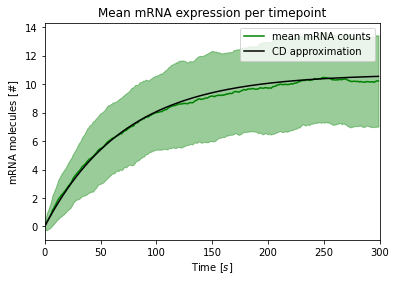

In [ ]:
plt.plot(grid, means, c='g', label='mean mRNA counts')
plt.fill_between(grid, means + stds, means - stds, color='g', alpha=0.4)

plt.plot(grid, (beta_s/k_null)*(1-np.exp(-k_null * grid)), c='k', label='CD approximation')

plt.xlim((0, 300))
plt.xlabel('Time $[s]$')
plt.ylabel('mRNA molecules $[\#]$')

plt.title('Mean mRNA expression per timepoint')
plt.legend()
plt.show()

## Q10.6 Probability of zero copies, via simulation


In [ ]:
idx_first_nonzero = results_df[results_df['mRNA'] > 0].groupby(['repeat'], sort=False)['time'].idxmin()
first_molecule_time = results_df.loc[idx_first_nonzero, 'time'].values
first_molecule_time[:4]

array([3.95133095, 7.86803513, 8.26790495, 2.0821514 ])

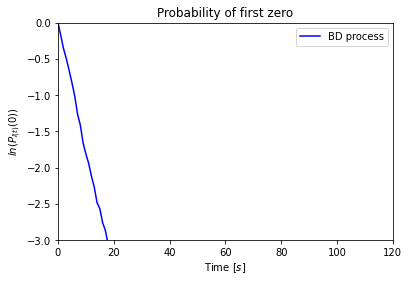

In [ ]:
grid_BD = np.arange(0, 120, 1)

p_zeros_BD = (grid_BD[:, None] < first_molecule_time[None, :]).sum(axis=1) / len(first_molecule_time)
p_zeros_BD = np.log(p_zeros_BD + 1e-5)

plt.plot(grid_BD, p_zeros_BD, c='b', label='BD process')

plt.xlim((0, 120))
plt.xlabel('Time $[s]$')

plt.ylim((-3, 0))
plt.ylabel('$ln(P_{l(t)}(0))$')

plt.title('Probability of first zero')
plt.legend()
plt.show()

The simulation graph looks nothing like the experimental data

## Q10.7 Simulate simplified bursting process
To simulate a bursting process, we will expand the state to include the gene copy number `n_genes`, and the active genes count `n_active`. We will add two new events - gene activation and gene deactivation, and alter the birth event to work only when there are active genes.

In [6]:
BurstState = namedtuple('BurstState', ['mRNA', 'n_genes', 'n_active'])

class BurstBirthEvent(Event):
  def __init__(self, beta_synthesis):
    self.beta_synthesis = beta_synthesis

    def rate_function(state):
      if state.n_active > 0:
        return self.beta_synthesis * state.n_active
      else:
        return 0.

    def event_function(state):
      return state._replace(mRNA=state.mRNA + 1)

    super().__init__(rate_function, event_function)


class ActivationEvent(Event):
  def __init__(self, beta_start):
    self.beta_start = beta_start

    def rate_function(state):
      inactive_count = state.n_genes - state.n_active
      return self.beta_start * inactive_count

    def event_function(state):
      return state._replace(n_active=state.n_active + 1)

    super().__init__(rate_function, event_function)


class DeActivationEvent(Event):
  def __init__(self, beta_stop):
    self.beta_stop = beta_stop

    def rate_function(state):
      return self.beta_stop * state.n_active

    def event_function(state):
      return state._replace(n_active=state.n_active - 1)

    super().__init__(rate_function, event_function)


In [7]:
BurstState(0, 1, 0)._fields

('mRNA', 'n_genes', 'n_active')

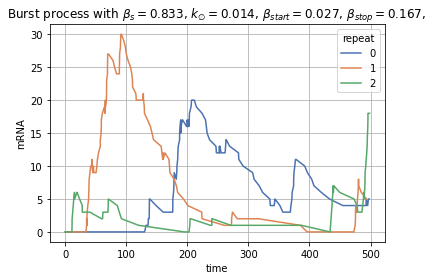

In [12]:
k_null = np.log(2)/50  # clearance_rate [min^-1]
beta_start = 1/37  # rate of turning genes on [min^-1]
beta_stop = 1/6  # rate of turning genes off [min^-1]
beta_s = 5 * beta_stop  # beta_synthesis [min^-1]

results_df = wrapper(3, 500, BurstState(0, 1, 0), [
    BurstBirthEvent(beta_s), DeathEvent(k_null), ActivationEvent(beta_start),
    DeActivationEvent(beta_stop)])

g = sns.lineplot(x='time', y='mRNA', hue='repeat', data=results_df, palette='deep')
plt.grid()
plt.title(fr'Burst process with $\beta_s={beta_s: .3f}$, $k_{{\varnothing}}' + \
          fr'={k_null: .3f}$, $\beta_{{start}}={beta_start: .3f}$, ' + \
          fr'$\beta_{{stop}}={beta_stop: .3f}$, ')
plt.show()

In [ ]:
k_null = np.log(2)/50  # clearance_rate [min^-1]
beta_start = 1/37  # rate of turning genes on [min^-1]
beta_stop = 1/6  # rate of turning genes off [min^-1]
beta_s = 5 * beta_stop  # beta_synthesis [min^-1]

reps = 300

results_df = wrapper(reps, 150, BurstState(0, 1, 0), [
    BurstBirthEvent(beta_s), DeathEvent(k_null), ActivationEvent(beta_start),
    DeActivationEvent(beta_stop)])

In [ ]:
grid = np.arange(0, 150, 1)
means = np.zeros_like(grid, dtype='float')
stds = np.zeros_like(grid, dtype='float')

for i, t in enumerate(grid):
  idxmax = results_df[results_df.time <= t].groupby(['repeat'], sort=False)['time'].idxmax()
  mRNA = results_df.loc[idxmax, 'mRNA'].values
  means[i] = mRNA.mean()
  stds[i] = mRNA.std()

means[:5]

array([0.        , 0.01666667, 0.03666667, 0.09333333, 0.13333333])

The Fano factor is  5.29


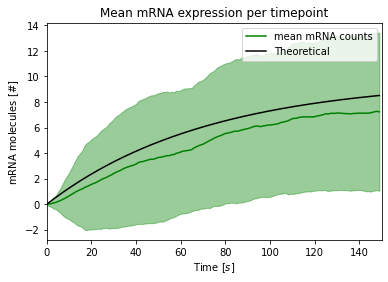

In [ ]:
plt.plot(grid, means, c='g', label='mean mRNA counts')
plt.fill_between(grid, means + stds, means - stds, color='g', alpha=0.4)

plt.plot(grid, ((beta_s/beta_stop) * beta_start/k_null)*(1-np.exp(-k_null * grid)), c='k', label='Theoretical')

plt.xlim((0, 150))
plt.xlabel('Time $[s]$')
plt.ylabel('mRNA molecules $[\#]$')

plt.title('Mean mRNA expression per timepoint')
plt.legend()

print(f'The Fano factor is {stds[-1]**2/means[-1]: .2f}')
plt.show()

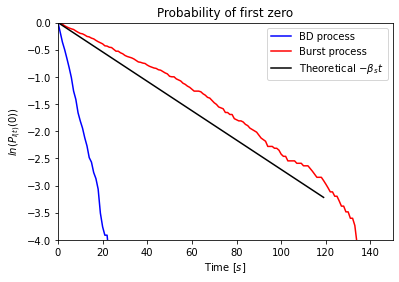

In [ ]:
idx_first_nonzero = results_df[results_df['mRNA'] > 0].groupby(['repeat'], sort=False)['time'].idxmin()
first_molecule_time = results_df.loc[idx_first_nonzero, 'time'].values

grid = np.arange(0, 150, 1)

p_zeros_burst = (grid[:, None] < first_molecule_time[None, :]).sum(axis=1) / len(first_molecule_time)
p_zeros_burst = np.log(p_zeros_burst + 1e-5)

plt.plot(grid_BD, p_zeros_BD, c='b', label='BD process')
plt.plot(grid, p_zeros_burst, c='r', label='Burst process')
plt.plot(grid_BD, -beta_start*grid_BD, c='k', label='Theoretical $-\\beta_s t$')

plt.xlim((0, 150))
plt.xlabel('Time $[s]$')

plt.ylim((-4, 0))
plt.ylabel('$ln(P_{l(t)}(0))$')

plt.title('Probability of first zero')
plt.legend()
plt.show()

# Q10.11 Simulate transcriptional bursting


## Simulation using a clock
To fully simulate the more elaborate process, we will add a `clock` state variable to better estimate gene duplication and dilution of mRNA by devision. We will also implement a clock ticking event, which might result in duplication of the genes or in dilution.

In [ ]:
FullState = namedtuple('BurstState', ['mRNA', 'n_genes', 'n_active', 'clock'])


class ClockIncrement(Event):
  def __init__(self, n_zero, ini_n_genes, duplication_time=0.3, n_start=0):
    self.n_zero = n_zero
    self.duplication_time = duplication_time
    self.ini_n_genes = ini_n_genes
    self.doubled = n_start > duplication_time * n_zero

    def rate_function(state):
      return self.n_zero / 50

    def event_function(state):
      if (state.clock + 1 >= self.duplication_time * self.n_zero) and not self.doubled:
        self.doubled = True
        return state._replace(clock=state.clock + 1,
                              n_genes=self.ini_n_genes * 2,
                              n_active=0)
      elif (state.clock + 1 >= self.n_zero):
        self.doubled = False
        mRNA = rng.binomial(state.mRNA, 0.5)
        active = rng.binomial(2, state.n_active / state.n_genes)
        return state._replace(mRNA=mRNA,
                              n_genes=self.ini_n_genes,
                              n_active=active,
                              clock=0)
      else:
        return state._replace(clock=state.clock + 1)


    super().__init__(rate_function, event_function)


In [ ]:
k_null = np.log(2)/50  # clearance_rate [min^-1]
beta_start = 1/37  # rate of turning genes on [min^-1]
beta_stop = 1/6  # rate of turning genes off [min^-1]
beta_s = 5 * beta_stop  # beta_synthesis [min^-1]
n_zero = 5  # n_0, effects when sampling the time [min^-1]
duplication_time = 0.3  # after what proportion of n_0 the genes duplicate [proportion]
ini_n_genes = 2  # initial number of genes

n_start = 0

ts, states = gillespie_simulation(10, FullState(0, ini_n_genes, 0, n_start), [
    BurstBirthEvent(beta_s), DeathEvent(k_null), ActivationEvent(beta_start),
    DeActivationEvent(beta_stop),
    ClockIncrement(n_zero, ini_n_genes, duplication_time, n_start)], verbrose=True)


Time  0.00, state is BurstState(mRNA=0, n_genes=2, n_active=0, clock=0)
rates are [0.         0.         0.05405405 0.         0.1       ]
Time  5.68, state is BurstState(mRNA=0, n_genes=2, n_active=0, clock=1)
rates are [0.         0.         0.05405405 0.         0.1       ]


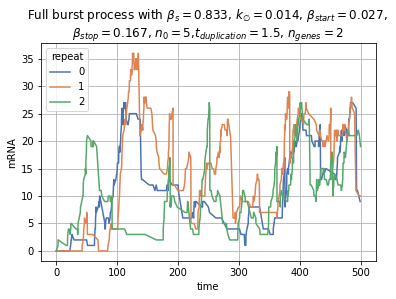

In [ ]:
k_null = np.log(2)/50  # clearance_rate [min^-1]
beta_start = 1/37  # rate of turning genes on [min^-1]
beta_stop = 1/6  # rate of turning genes off [min^-1]
beta_s = 5 * beta_stop  # beta_synthesis [min^-1]
n_zero = 5  # n_0, effects when sampling the time [min^-1]
duplication_time = 0.3  # after what proportion of n_0 the genes duplicate [proportion]
ini_n_genes = 2  # initial number of genes

results_df = wrapper(3, 500, FullState(0, ini_n_genes, 0, 0), [
    BurstBirthEvent(beta_s), DeathEvent(k_null), ActivationEvent(beta_start),
    DeActivationEvent(beta_stop),
    ClockIncrement(n_zero, ini_n_genes, duplication_time)])

g = sns.lineplot(x='time', y='mRNA', hue='repeat', data=results_df, palette='deep')
plt.grid()
plt.title(fr'Full burst process with $\beta_s={beta_s: .3f}$, $k_{{\varnothing}}' + \
          fr'={k_null: .3f}$, $\beta_{{start}}={beta_start: .3f}$, ' + '\n' + \
          fr'$\beta_{{stop}}={beta_stop: .3f}$, $n_0={n_zero}$,' + \
          fr'$t_{{duplication}}={duplication_time * n_zero: .1f}$,' + \
          fr' $n_{{genes}}={ini_n_genes}$')
plt.show()

## Loading the experimental dataset

In [ ]:
pikle = np.load(np.DataSource().open('http://www.physics.upenn.edu/biophys/PMLS2e/Datasets/Bursting/GoldingData.npz', "rb"))
data = dict(pikle.items())
data.keys()

dict_keys(['panelD2', 'panelD1', 'panelD3', 'panelC', 'panelA2', 'panelA3', 'panelA1'])

In [ ]:
dfs = []
for i in range(1, 4):
    dfs.append(pd.DataFrame(data['panelA'+str(i)], columns=['time', 'sample_mean']))
    dfs[-1].insert(0, 'trial', i)
df_panelA = pd.concat(dfs).reset_index(drop=True)
df_panelA

,trial,time,sample_mean
0,1,0.3991,0.0403
1,1,10.1822,0.6633
2,1,20.1313,3.3149
3,1,30.1302,2.9842
4,1,39.9096,3.8303
5,1,49.8898,4.6155
6,1,59.8721,5.2789
7,1,90.1907,8.9527
8,1,120.1771,8.5693
9,2,0.1995,0.0202


In [ ]:
dfs = []
for i in range(1, 4):
    dfs.append(pd.DataFrame(data['panelD'+str(i)], columns=['time', 'log_p_zero']))
    dfs[-1].insert(0, 'trial', i)
df_panelD = pd.concat(dfs).reset_index(drop=True)
df_panelD

,trial,time,log_p_zero
0,1,2.842200e-14,0.002168
1,1,1.004780e+01,-0.241100
2,1,2.009570e+01,-0.753200
3,1,2.993850e+01,-1.113600
4,1,3.998630e+01,-1.430600
5,1,5.003420e+01,-1.522100
6,1,6.028710e+01,-1.284100
7,1,9.022560e+01,-2.139600
8,1,1.201640e+02,-2.080200
9,2,-2.051000e-01,-0.106200


In [ ]:
df_panelC = pd.DataFrame(data['panelC'], columns=['log_10_mean', 'log_10_var'])
df_panelC

,log_10_mean,log_10_var
0,-1.0982,-0.6848
1,-0.9216,-0.7097
2,-0.7737,-0.1450
3,-0.7546,-0.2056
4,-0.4349,0.2387
5,-0.3204,0.2307
6,-0.0675,0.8134
7,0.3572,0.8767
8,0.6387,0.9651
9,0.6339,1.6590


## Reproducing the data with our model
After some thought about fitting $\beta_start$, I realised different cells are in different positions of the cell cycle, meaning the start rate should consider the cell cycle effect on the gene copy number. In the simulation, different copy numbers at the begining can be reflected using in the clock's initial state

In [ ]:
def wrapper_clock(repeats, T, k_null, beta_start, beta_stop, beta_s,
                  n_zero, d_time, ini_n_genes, verbrose=False):
  dfs = []
  startings = rng.choice(n_zero, size=repeats)

  for repeat in range(repeats):
    clock_i = ClockIncrement(n_zero, ini_n_genes, d_time, startings[repeat])
    events = [BurstBirthEvent(beta_s), DeathEvent(k_null), clock_i,
              ActivationEvent(beta_start), DeActivationEvent(beta_stop)]
    starting_genes = 2 * ini_n_genes if clock_i.doubled else ini_n_genes
    ini_state = FullState(0, starting_genes, 0, startings[repeat])

    ts, states = gillespie_simulation(T, ini_state, events, verbrose)

    dfs.append(pd.DataFrame(states, columns=ini_state._fields))
    dfs[-1].insert(0, 'repeat', repeat)
    dfs[-1].insert(1, 'time', ts)

  return pd.concat(dfs).reset_index(drop=True)

results_df = wrapper_clock(1, 30, k_null, beta_start, beta_stop, beta_s, n_zero,
              duplication_time, ini_n_genes, verbrose=True)

Time  0.00, state is BurstState(mRNA=0, n_genes=4, n_active=0, clock=3)
rates are [0.         0.         0.1        0.10810811 0.        ]
Time  13.74, state is BurstState(mRNA=0, n_genes=4, n_active=1, clock=3)
rates are [0.83333333 0.         0.1        0.08108108 0.16666667]
Time  14.41, state is BurstState(mRNA=1, n_genes=4, n_active=1, clock=3)
rates are [0.83333333 0.01386294 0.1        0.08108108 0.16666667]
Time  14.87, state is BurstState(mRNA=2, n_genes=4, n_active=1, clock=3)
rates are [0.83333333 0.02772589 0.1        0.08108108 0.16666667]
Time  16.00, state is BurstState(mRNA=3, n_genes=4, n_active=1, clock=3)
rates are [0.83333333 0.04158883 0.1        0.08108108 0.16666667]
Time  16.65, state is BurstState(mRNA=3, n_genes=4, n_active=1, clock=4)
rates are [0.83333333 0.04158883 0.1        0.08108108 0.16666667]
Time  16.84, state is BurstState(mRNA=4, n_genes=4, n_active=1, clock=4)
rates are [0.83333333 0.05545177 0.1        0.08108108 0.16666667]
Time  16.88, state is

In [ ]:
reps = 300
time = 200

beta_stop = 1/6.5  # rate of turning genes off [min^-1]
beta_s = 7 * beta_stop  # beta_synthesis [min^-1]
duplication_time = 0.3  # after what proportion of n_0 the genes duplicate [proportion]
ini_n_genes = 2  # initial number of genes

n_zero = 5

# the measured beta start is for the average gene count
average_starting_genes = 2 + 2 * (1 - duplication_time)
beta_start = 1/35 / average_starting_genes

# we implemented the dilution, so we need much smaller clearance rate
k_null = 0.014 - np.log(2)/50 #

results_df = wrapper_clock(reps, time, k_null, beta_start, beta_stop, beta_s,
                           n_zero, duplication_time, ini_n_genes)


In [ ]:
grid_time = np.arange(0, time, 2)
means = np.zeros_like(grid_time, dtype='float')
stds = np.zeros_like(grid_time, dtype='float')

for i, t in enumerate(grid_time):
  idxmax = results_df[results_df.time <= t].groupby(['repeat'], sort=False)['time'].idxmax()
  mRNA = results_df.loc[idxmax, 'mRNA'].values
  means[i] = mRNA.mean()
  stds[i] = mRNA.std()


The Fano factor is  7.15


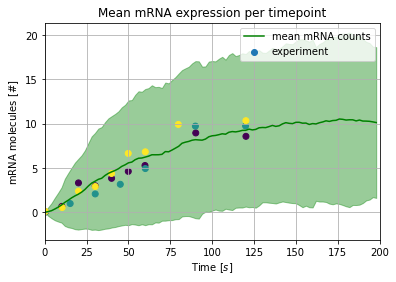

In [ ]:
plt.plot(grid_time, means, c='g', label='mean mRNA counts')
plt.fill_between(grid_time, means + stds, means - stds, color='g', alpha=0.4)

plt.scatter('time', 'sample_mean', c='trial', data=df_panelA, label='experiment')

plt.xlim((0, time))
plt.xlabel('Time $[s]$')

plt.ylabel('mRNA molecules $[\#]$')

plt.grid()
plt.title('Mean mRNA expression per timepoint')
plt.legend()

print(f'The Fano factor is {stds[-1]**2/means[-1]: .2f}')
plt.show()

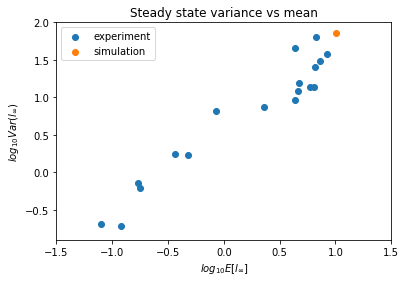

In [ ]:
plt.scatter('log_10_mean', 'log_10_var', data=df_panelC, label='experiment')
plt.scatter(np.log10(means[-1]), 2 * np.log10(stds[-1]), label='simulation')

plt.xlim((-1.5, 1.5))
plt.xlabel('$log_{10} E[l_{\\infty}]$')

plt.ylim((-0.9, 2))
plt.ylabel('$log_{10} Var(l_{\\infty})$')

plt.title('Steady state variance vs mean')
plt.legend()
plt.show()

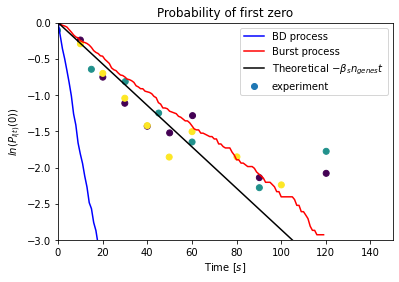

In [ ]:
idx_first_nonzero = results_df[results_df['mRNA'] > 0].groupby(['repeat'], sort=False)['time'].idxmin()
first_molecule_time = results_df.loc[idx_first_nonzero, 'time'].values

grid = np.arange(0, 120, 1)

p_zeros_burst = (grid[:, None] < first_molecule_time[None, :]).sum(axis=1) / len(first_molecule_time)
p_zeros_burst = np.log(p_zeros_burst + 1e-5)

plt.plot(grid_BD, p_zeros_BD, c='b', label='BD process')
plt.plot(grid, p_zeros_burst, c='r', label='Burst process')
plt.plot(grid_BD, -beta_start * average_starting_genes * grid_BD, c='k', label='Theoretical $-\\beta_s n_{genes} t$')
plt.scatter('time', 'log_p_zero', c='trial', data=df_panelD, label='experiment')

plt.xlim((0, 150))
plt.xlabel('Time $[s]$')

plt.ylim((-3, 0))
plt.ylabel('$ln(P_{l(t)}(0))$')

plt.title('Probability of first zero')
plt.legend()
plt.show()

# conclusions
I've seem to somehow manage to reproduce the results. The simulation decisions I've made:

1.  Initiating the cells in a veriety of clock states when trying to fit $\beta_{start}$. This imitates the fact that the cells are cycling prior to the induction, and thus the effective gene copy number is $n_{effective} = 2 \cdot (1 + n_{doubled}) = 2 + 2 \cdot (1 - 0.3) = 3.4$.

2.  I've scaled $\beta_{start}$ by $n_{effective}$, as the initial burst is dependent on the effective amount of genes.

3.  Our model (and life) deactivates genes when they are doubled, and that seems fair. But as we deactivate the genes at the splitting as well, this reduces the activity. To prevent this, I've adjusted the after split active gene count to a binomial(2, active/total genes).

4. Our model explicitly dilutes the mRNA molecule, so the death rate of $ln(2)/50$ is exsesive, and I've left it at around $10^{-4}$